In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [17]:
pd.set_option('display.min_rows', 100)

In [18]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.colormaps.get_cmap(name)(np.linspace(0.1, 0.8, n))

In [47]:
with open("metrics_16p_4b_21n_pinned_2.json") as f:
    raw = json.load(f)
points = pd.json_normalize(raw)
points.rename(columns={
    "labels.status": "status", 
    "labels.provider": "provider",
    "labels.size": "size",
    "labels.epoch": "epoch"
}, inplace=True)
points["end"] = points['start'] + points['duration']

In [48]:
success = points[points["status"] == "success"].sort_values(by='start')
confirmed = points[points["status"] == "confirmed"].sort_values(by='start')
invalid = points[points["status"] == "invalid"].sort_values(by='start')

In [49]:
success.shape

(587, 9)

In [50]:
success["duration"].median()

4826.039673089981

In [51]:
confirmed["duration"].median()

24897.000925064087

In [52]:
epoches = success[["start", "end", "epoch"]].copy()
epoches = epoches.groupby("epoch").agg(start=('start', 'min'), end=('start', 'max')).reset_index()
epoches["end"] = epoches["end"] + success["duration"].median()
epoches["duration"] = epoches["end"] - epoches["start"]

In [53]:
epoches

,epoch,start,end,duration
0,6,1.970843e+05,5.105442e+05,313459.931025
1,7,6.683953e+05,8.032821e+05,134886.821278
2,8,9.388477e+05,1.098881e+06,160033.321803
3,9,1.234452e+06,1.411483e+06,177031.117619
4,10,1.545076e+06,1.709542e+06,164465.416680
5,11,1.835661e+06,2.015094e+06,179432.677496
6,12,2.161301e+06,2.300650e+06,139348.954414


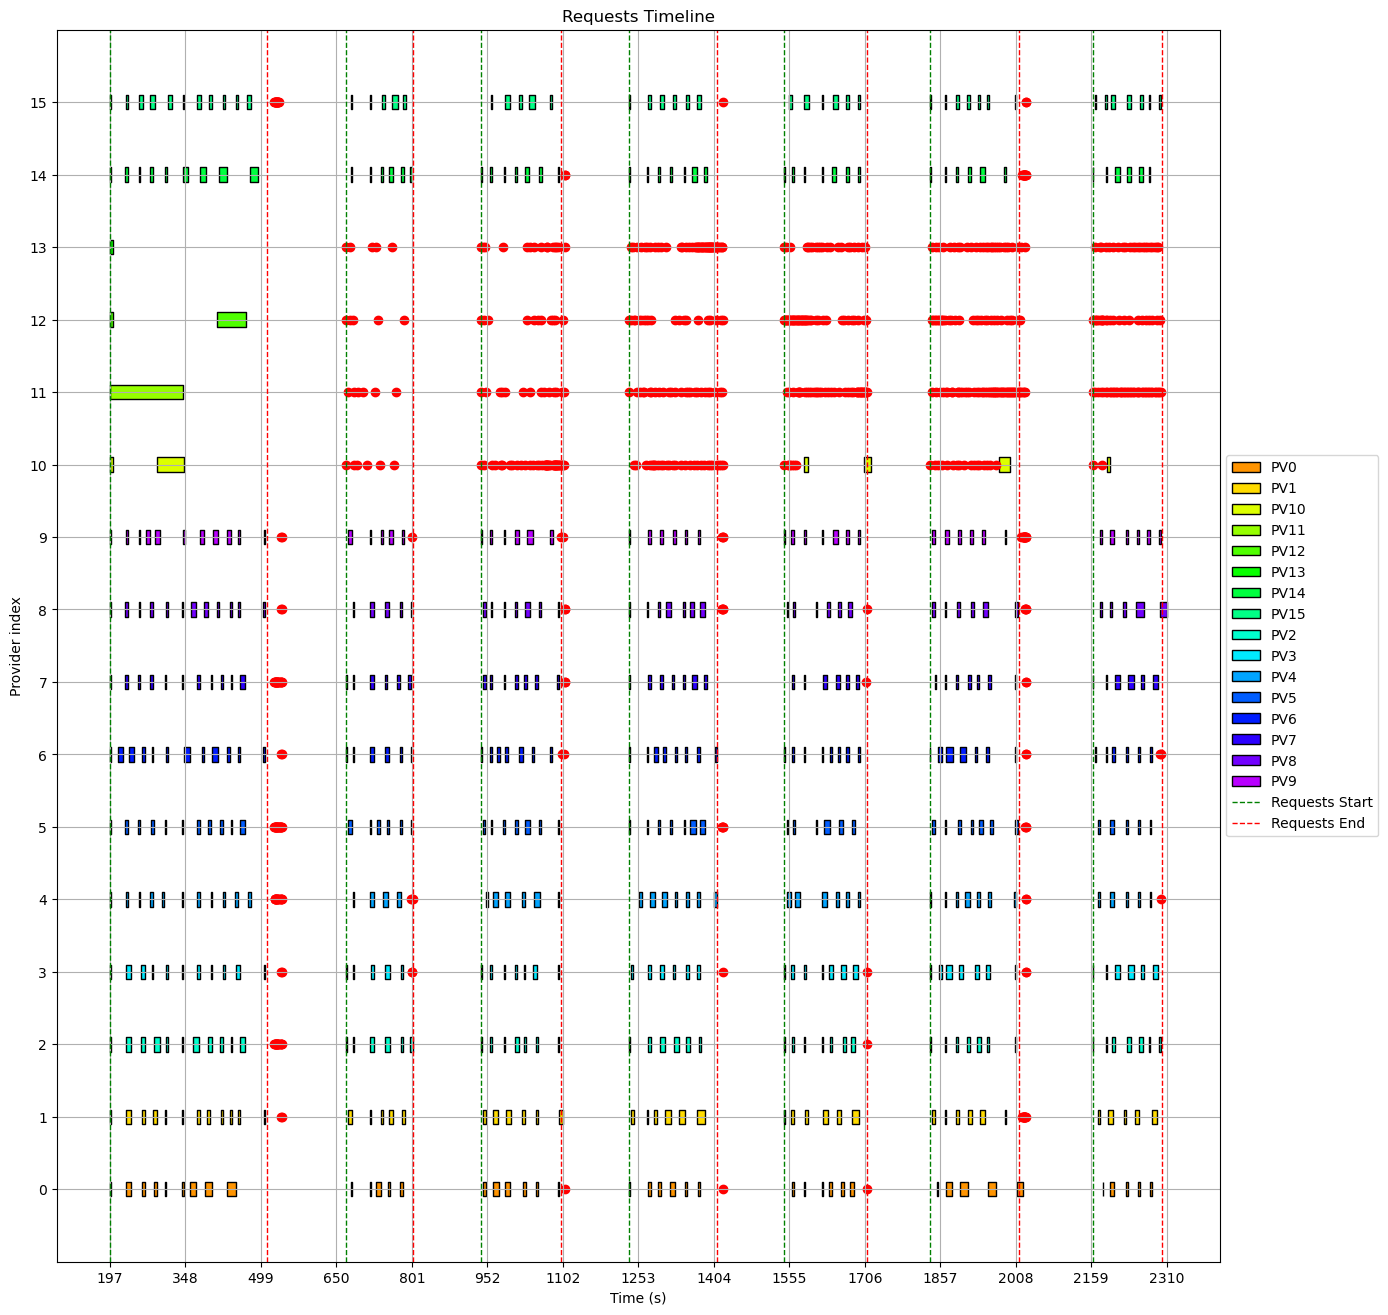

In [54]:
FACTOR = 1e3
count = len(points['provider'].unique())
plt.figure(figsize=(15, count))
cmap = get_cmap(count)

for i, (pv, group) in enumerate(success.groupby('provider')):
    data = list(zip(group['start'] / FACTOR, group['duration']  / FACTOR))
    pnum = int(pv[2:])
    plt.broken_barh(data, (pnum-0.1, 0.2), edgecolor='black', facecolor=cmap[i], label=pv)

for i, (pv, group) in enumerate(invalid.groupby('provider')):
    data = group['start'] / FACTOR
    pnum = int(pv[2:])
    plt.scatter(data, [pnum] * len(data), color="red")

for i, row in epoches.iterrows():
    plt.axvline(x=row['start'] / FACTOR, color='g', linestyle='--', linewidth=1, label='Requests Start' if i == 0 else "")
    plt.axvline(x=row['end'] / FACTOR, color='r', linestyle='--', linewidth=1, label='Requests End' if i == 0 else "")

# Formatting
plt.xticks(np.linspace(success["start"].min() / FACTOR, success["end"].max() / FACTOR, 15))
plt.yticks(np.linspace(0, count - 1, count))

plt.xlabel('Time (s)')
plt.ylabel('Provider index')
plt.title('Requests Timeline')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-1, count)
plt.grid(True)
plt.show()

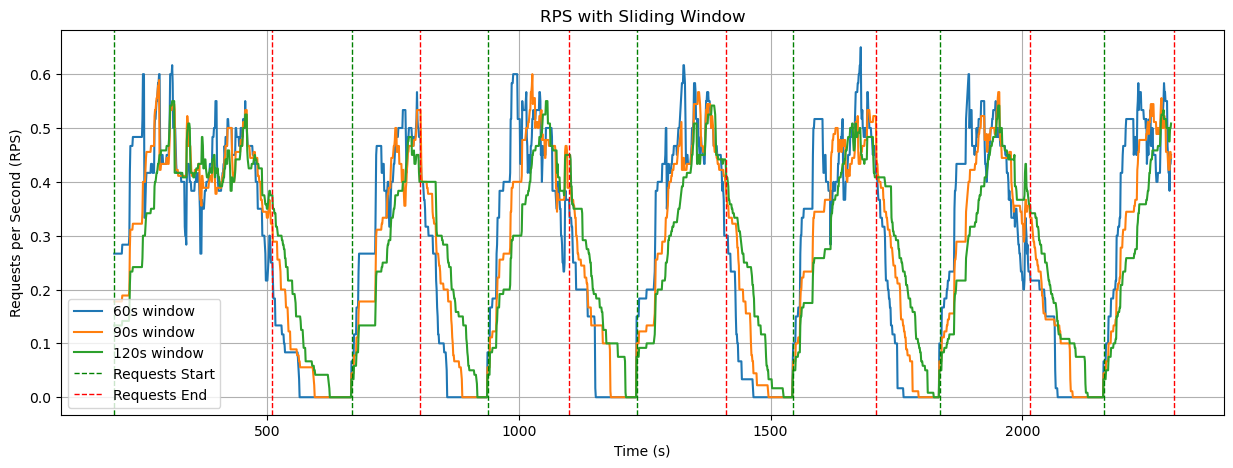

In [55]:
reqs = success[["start", "size"]].copy()
reqs["start"] = pd.to_timedelta(reqs["start"], unit="ms")
reqs = reqs.groupby("start")["size"].sum()

# Resample to 1-second frequency
resampled = reqs.resample('1S').sum()

FACTOR = 1e9
def plot_window(window_size):
    rps = resampled.rolling(window=window_size, min_periods=0).sum() / window_size
    plt.plot(rps.index / FACTOR, rps.values, label="{}s window".format(window_size))

plt.figure(figsize=(15, 5))
# Plot
plot_window(60)
plot_window(90)
plot_window(120)

for i, row in epoches.iterrows():
    start = pd.to_timedelta(row['start'], unit="ms") / pd.Timedelta(1, 'ns')
    plt.axvline(x=start / FACTOR, color='g', linestyle='--', linewidth=1, label='Requests Start' if i == 0 else "")
    end = pd.to_timedelta(row['end'], unit="ms") / pd.Timedelta(1, 'ns')
    plt.axvline(x=end / FACTOR, color='r', linestyle='--', linewidth=1, label='Requests End' if i == 0 else "")

plt.xlabel('Time (s)')
plt.ylabel('Requests per Second (RPS)')
plt.title('RPS with Sliding Window')
plt.grid(True)
plt.legend()
plt.show()

In [56]:
erps = []
for (i, epoch) in epoches.iterrows():
    count = success[success["epoch"] == epoch["epoch"]]["size"].sum()
    rps = count / epoch["duration"] * 1000
    erps.append(rps)
    print(rps)
pd.Series(erps).median()

0.4370574559625652
0.47447185272497183
0.48739849377101724
0.4462492304319298
0.48642445089601033
0.4402765488564941
0.5023360260886347


0.47447185272497183

In [14]:
def process(datas):
    res = dict()
    for line in datas.split("\n"):
        words = line.split(" ")
        res[words[0]] = list(map(float, words[-3:]))
    return res

batches = dict()
# Data gathered from aggregating actor log
batches["1"] = """from_raw 2137 1.4016078614881 1.67 1.7792 1.96
pack 2129 476299.10615312 484829.4 486830.4 491330.6
randomx 2129 476283.73461719 484815 486815.2 491316.76"""
batches["2"] = """from_raw 2093 1.4917166746297 1.8 1.91 2.1916
pack 2094 598354.48185291 626291.3 629699.4 636137.91
randomx 2094 598336.06064947 626273.6 629677 636121.35"""
batches["3"] = """from_raw 2245 1.5433224944321 1.9 2.0308 2.33
pack 2236 726489.93872987 761149 767902.5 780270.95
randomx 2236 726470.12209302 761130.5 767885 780253.65"""
batches["4"] = """from_raw 2134 1.6584062792877 2.071 2.26 2.6867
pack 2125 873428.26588235 942962.6 957103.2 976011.52
randomx 2125 873406.89647059 942941 957080.4 975992.8"""

batches = {k: process(v) for k, v in batches.items()}

Text(0, 0.5, 'Time (us)')

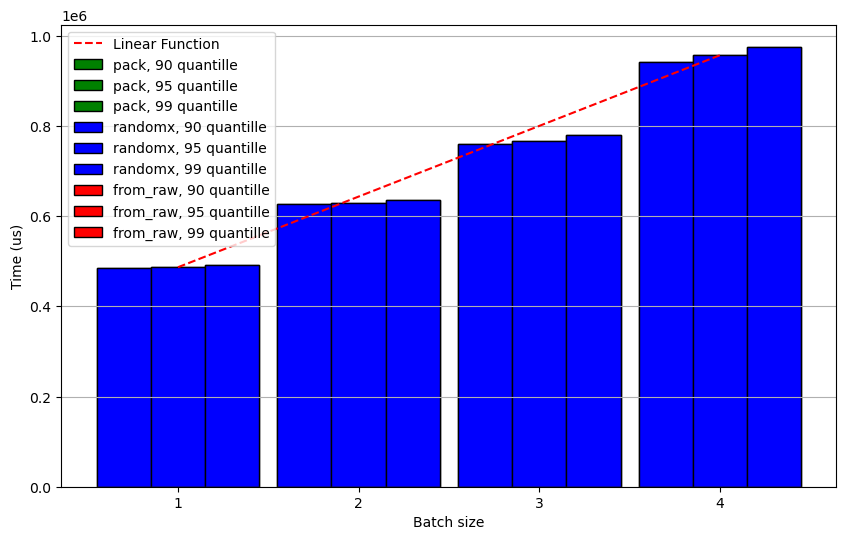

In [15]:
plt.figure(figsize=(10, 6))

x_range = [int(b) for b in batches]
width = 0.3
colors = {
    "from_raw": "red",
    "randomx": "blue",
    "pack": "green"
}
quants = {
    0: "90",
    1: "95",
    2: "99"
}

for process in ["pack", "randomx", "from_raw"]:
    for q, qlabel in quants.items():
        x_r = [x - width * (len(quants) // 2 - q) for x in x_range]
        values = [v[process][q] for v in batches.values()]
        plt.bar(x_r, values, width, color=colors[process], edgecolor="black", label=f"{process}, {qlabel} quantille")

x = [min(x_range), max(x_range)]
y = [batches["1"]["randomx"][1], batches["4"]["randomx"][1]]

plt.plot(x, y, color="red", linestyle="--", label="Linear Function")

plt.legend()
plt.grid(True, axis="y")
plt.xticks(x_range, batches.keys())
plt.xlabel("Batch size")
plt.ylabel("Time (us)")